# Director Gender Bias in Movie Ratings

## Import Statements

In [1]:
!pip install scikit-surprise

In [2]:
import random
from sklearn import linear_model
from matplotlib import pyplot as plt
from collections import defaultdict
import gzip
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score

import json
import numpy
import dateutil.parser
import math
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import scipy.optimize
from sklearn import svm
import string
import random

from surprise import Dataset, Reader, accuracy
from surprise.model_selection import train_test_split
from surprise.prediction_algorithms.matrix_factorization import SVD
# from implicit.als import AlternatingLeastSquares
import numpy as np
import os
import tarfile

In [3]:
#Install AIF360
!pip install 'aif360'

ERROR: Invalid requirement: "'aif360'"


In [4]:
# Install TensorFlow
!pip install 'tensorflow==2.6.0'

ERROR: Invalid requirement: "'tensorflow==2.6.0'"


In [5]:
pip install 'aif360[LawSchoolGPA]'

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'aif360[LawSchoolGPA]'"


In [6]:
pip install --upgrade tensorflow aif360

  Using cached protobuf-4.25.2-cp39-cp39-win_amd64.whl.metadata (541 bytes)
  Using cached protobuf-4.23.4-cp39-cp39-win_amd64.whl.metadata (540 bytes)
Using cached protobuf-4.23.4-cp39-cp39-win_amd64.whl (422 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.0
    Uninstalling protobuf-3.19.0:
      Successfully uninstalled protobuf-3.19.0
Note: you may need to restart the kernel to use updated packages.


In [7]:
pip install protobuf==3.19.0

  Using cached protobuf-3.19.0-cp39-cp39-win_amd64.whl (895 kB)
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.23.4
    Uninstalling protobuf-4.23.4:
      Successfully uninstalled protobuf-4.23.4
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorboard 2.15.1 requires protobuf<4.24,>=3.19.6, but you have protobuf 3.19.0 which is incompatible.
tensorflow-intel 2.15.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.20.3, but you have protobuf 3.19.0 which is incompatible.


In [8]:
pip install 'aif360[AdversarialDebiasing]'

Note: you may need to restart the kernel to use updated packages.


ERROR: Invalid requirement: "'aif360[AdversarialDebiasing]'"


In [9]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import DisparateImpactRemover
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

pip install 'aif360[AdversarialDebiasing]'
pip install 'aif360[AdversarialDebiasing]'


## Reading File Path

In [10]:
# Update the file paths based on your extraction path
extract_path = ""

# Ratings File
ratings_file = os.path.join(extract_path, "ratings.dat")
ratings_columns = ["UserID", "MovieID", "Rating", "Timestamp"]
ratings_df = pd.read_csv(ratings_file, sep="::", engine="python", header=None, names=ratings_columns, encoding='latin1')

# Users File
users_file = os.path.join(extract_path, "users.dat")
users_columns = ["UserID", "Gender", "Age", "Occupation", "Zip-code"]
users_df = pd.read_csv(users_file, sep="::", engine="python", header=None, names=users_columns, encoding='latin1')

# Movies File
movies_file = os.path.join(extract_path, "movies.dat")
movies_columns = ["MovieID", "Title", "Genres"]
movies_df = pd.read_csv(movies_file, sep="::", engine="python", header=None, names=movies_columns, encoding='latin1')

In [11]:
# Directors File
directors_file = os.path.join(extract_path, "directors.json")
directors_df = pd.read_json(directors_file)

In [12]:
# Titles File
titles_file = os.path.join(extract_path, "title.basics.tsv.gz")
titles_df = pd.read_csv(titles_file, compression='gzip', sep='\t', encoding='utf-8')

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.


## Combine Datasets

In [13]:
import re

# Separate title of movie from the year
movies_df['Year'] = movies_df['Title'].apply(lambda x: re.search(r'\((\d{4})\)', x).group(1) if re.search(r'\((\d{4})\)', x) else None)
movies_df['Title'] = movies_df['Title'].apply(lambda x: re.sub(r'\(\d{4}\)', '', x).strip())
movies_df

,MovieID,Title,Genres,Year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995
...,...,...,...,...
3878,3948,Meet the Parents,Comedy,2000
3879,3949,Requiem for a Dream,Drama,2000
3880,3950,Tigerland,Drama,2000
3881,3951,Two Family House,Drama,2000


In [14]:
# Filter to get titles that are only associated with movies

titles_df = titles_df[titles_df['titleType'] == 'movie']
titles_df

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
8,tt0000009,movie,Miss Jerry,Miss Jerry,0,1894,\N,45,Romance
144,tt0000147,movie,The Corbett-Fitzsimmons Fight,The Corbett-Fitzsimmons Fight,0,1897,\N,100,"Documentary,News,Sport"
498,tt0000502,movie,Bohemios,Bohemios,0,1905,\N,100,\N
570,tt0000574,movie,The Story of the Kelly Gang,The Story of the Kelly Gang,0,1906,\N,70,"Action,Adventure,Biography"
587,tt0000591,movie,The Prodigal Son,L'enfant prodigue,0,1907,\N,90,Drama
...,...,...,...,...,...,...,...,...,...
10491987,tt9916622,movie,Rodolpho Teóphilo - O Legado de um Pioneiro,Rodolpho Teóphilo - O Legado de um Pioneiro,0,2015,\N,57,Documentary
10492014,tt9916680,movie,De la ilusión al desconcierto: cine colombiano...,De la ilusión al desconcierto: cine colombiano...,0,2007,\N,100,Documentary
10492026,tt9916706,movie,Dankyavar Danka,Dankyavar Danka,0,2013,\N,\N,Comedy
10492036,tt9916730,movie,6 Gunn,6 Gunn,0,2017,\N,116,Drama


In [15]:
# Merge datasets using Title of movie and year

movie_ids = pd.merge(movies_df, titles_df, left_on=['Title', 'Year'], right_on=['primaryTitle', 'startYear'], how='left')
movie_ids

,MovieID,Title,Genres,Year,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres
0,1,Toy Story,Animation|Children's|Comedy,1995,tt0114709,movie,Toy Story,Toy Story,0,1995,\N,81,"Adventure,Animation,Comedy"
1,2,Jumanji,Adventure|Children's|Fantasy,1995,tt0113497,movie,Jumanji,Jumanji,0,1995,\N,104,"Adventure,Comedy,Family"
2,3,Grumpier Old Men,Comedy|Romance,1995,tt0113228,movie,Grumpier Old Men,Grumpier Old Men,0,1995,\N,101,"Comedy,Romance"
3,4,Waiting to Exhale,Comedy|Drama,1995,tt0114885,movie,Waiting to Exhale,Waiting to Exhale,0,1995,\N,124,"Comedy,Drama,Romance"
4,5,Father of the Bride Part II,Comedy,1995,tt0113041,movie,Father of the Bride Part II,Father of the Bride Part II,0,1995,\N,106,"Comedy,Family,Romance"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,3948,Meet the Parents,Comedy,2000,tt0212338,movie,Meet the Parents,Meet the Parents,0,2000,\N,108,"Comedy,Romance"
3896,3949,Requiem for a Dream,Drama,2000,tt0180093,movie,Requiem for a Dream,Requiem for a Dream,0,2000,\N,102,Drama
3897,3950,Tigerland,Drama,2000,tt0170691,movie,Tigerland,Tigerland,0,2000,\N,101,"Drama,War"
3898,3951,Two Family House,Drama,2000,tt0202641,movie,Two Family House,Two Family House,0,2000,\N,108,"Comedy,Drama,Romance"


In [16]:
# Find gender of each movie identifier associated with the director

genders = directors_df.explode('movies_list')
genders = pd.concat([genders.drop(['movies_list'], axis=1),
                         genders['movies_list'].apply(pd.Series)], axis=1)

In [17]:
# Combine datasets based on movie identifier 

merged_df = pd.merge(movie_ids, genders, left_on='tconst', right_on='movie_id', how='left')
merged_df = merged_df.loc[:, ['MovieID', 'Title', 'Genres', 'Year', 'male_count', 'gender', 'name', 'female_count']]
merged_df

,MovieID,Title,Genres,Year,male_count,gender,name,female_count
0,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0
1,2,Jumanji,Adventure|Children's|Fantasy,1995,11.0,male,Joe Johnston,0.0
2,3,Grumpier Old Men,Comedy|Romance,1995,3.0,male,Howard Deutch,0.0
3,4,Waiting to Exhale,Comedy|Drama,1995,116.0,male,Forest Whitaker,5.0
4,5,Father of the Bride Part II,Comedy,1995,2.0,male,Charles Shyer,0.0
...,...,...,...,...,...,...,...,...
4075,3948,Meet the Parents,Comedy,2000,8.0,male,Jay Roach,0.0
4076,3949,Requiem for a Dream,Drama,2000,33.0,male,Darren Aronofsky,3.0
4077,3950,Tigerland,Drama,2000,24.0,male,Joel Schumacher,3.0
4078,3951,Two Family House,Drama,2000,NaN,NaN,NaN,NaN


## Checking for Null Values for Each Dataframe

In [18]:
# Check for null values in merged movies dataset
merged_df.isnull().sum()

MovieID            0
Title              0
Genres             0
Year               0
male_count      2298
gender          2298
name            2298
female_count    2298
dtype: int64

In [19]:
# Check for null values in Ratings file
ratings_df.isnull().sum()

UserID       0
MovieID      0
Rating       0
Timestamp    0
dtype: int64

In [20]:
# Check for null values in Users file
users_df.isnull().sum()

UserID        0
Gender        0
Age           0
Occupation    0
Zip-code      0
dtype: int64

In [21]:
# Check for null values in Movies file

movies_df.isnull().sum()

MovieID    0
Title      0
Genres     0
Year       0
dtype: int64

# Data Cleaning EDA

### Movies Dataframe

In [22]:
%matplotlib inline

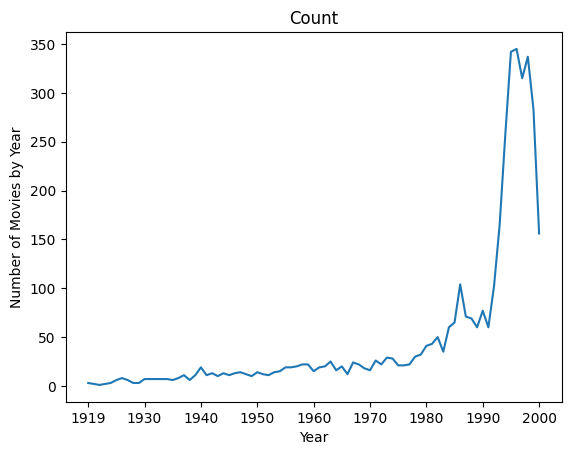

In [23]:
# Number of Movies in dataset by Year

movies_df['Year'].value_counts().sort_index().plot()
plt.ylabel('Number of Movies by Year')
plt.xlabel('Year')
plt.title('Count')
plt.show()

### Ratings Dataframe

Text(0, 0.5, 'Count')

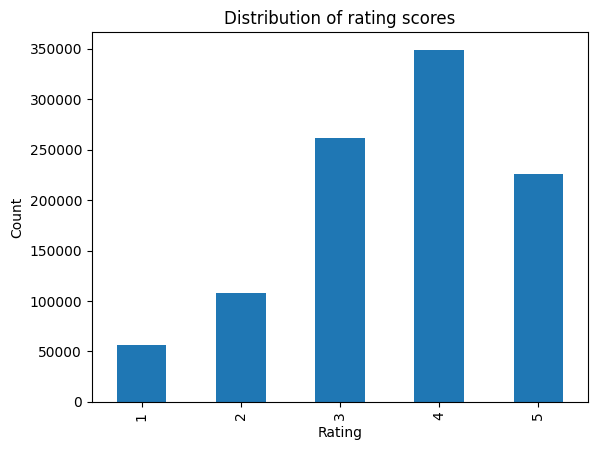

In [28]:
# Plot distribution of rating scores
ratings_df['Rating'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of rating scores')
plt.ylabel('Count')

# There do not appear to be any placeholders for missing vals
# Most ratings are 4 stars, the least amount of ratings are 1 star

Text(0, 0.5, 'Count')

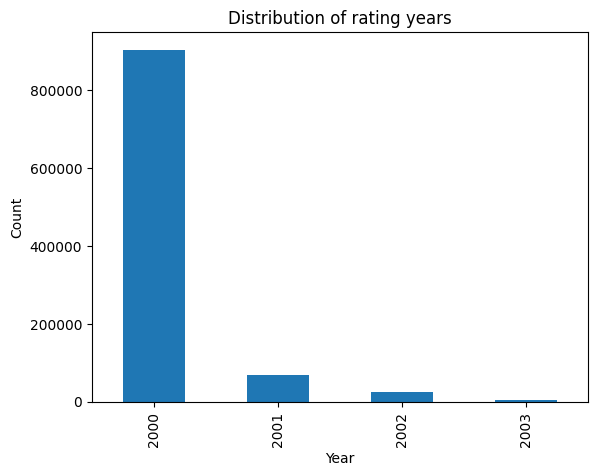

In [29]:
# Convert Timestamp col to datetime objects for visualizations
datetime = pd.to_datetime(ratings_df['Timestamp'], unit='s')

# Plot year of rating
datetime.dt.year.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of rating years')
plt.xlabel('Year')
plt.ylabel('Count')

# Almost all ratings are from 2000

Text(0, 0.5, 'Count')

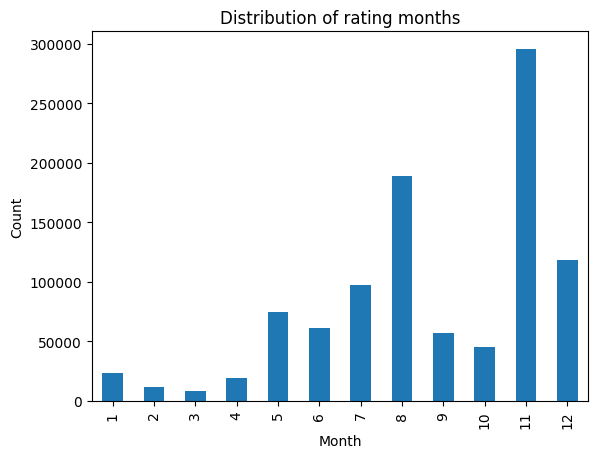

In [30]:
# Plot months of rating
datetime.dt.month.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of rating months')
plt.xlabel('Month')
plt.ylabel('Count')

# Most ratings are from November

Text(0, 0.5, 'Count')

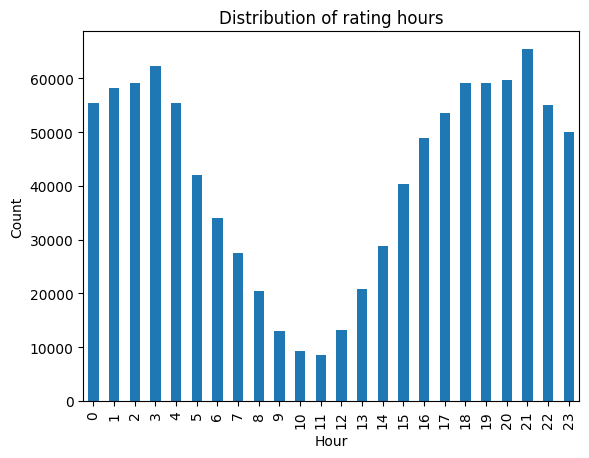

In [31]:
# Plot hour of rating
datetime.dt.hour.value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of rating hours')
plt.xlabel('Hour')
plt.ylabel('Count')

# Most ratings happen at the beginning of the day or the end, as that's where peaks happen.

In [32]:
# There do not appear to be any placeholders for null values
ratings_df['UserID'].min(), ratings_df['UserID'].max()

(1, 6040)

In [33]:
# Top 5 user IDs who left the most ratings
ratings_df['UserID'].value_counts()[:5]

UserID
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
Name: count, dtype: int64

In [34]:
# There do not appear to be any placeholders for null values
ratings_df['MovieID'].min(), ratings_df['MovieID'].max()

(1, 3952)

### Users Dataframe

Text(0, 0.5, 'Count')

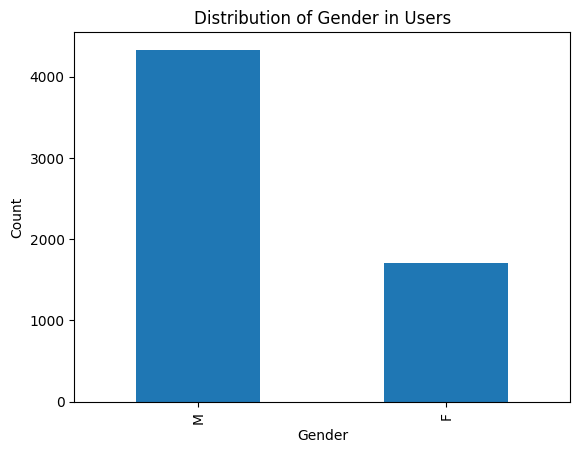

In [35]:
# Distribution of Gender in Users
users_df['Gender'].value_counts().plot(kind='bar')
plt.title('Distribution of Gender in Users')
plt.xlabel('Gender')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

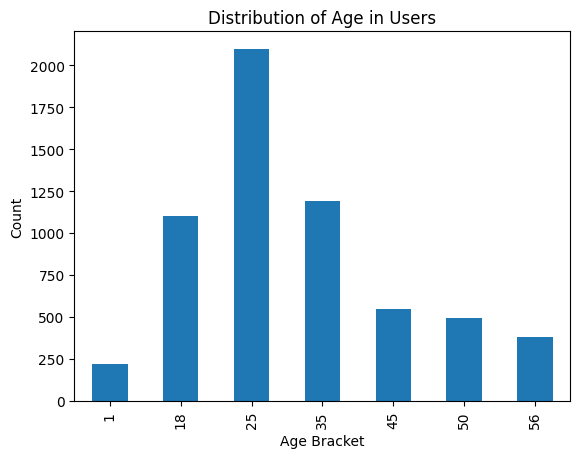

In [36]:
# Distribution of Age in Users
users_df['Age'].value_counts().sort_index().plot(kind='bar')
plt.title('Distribution of Age in Users')
plt.xlabel('Age Bracket')
plt.ylabel('Count')

## User, Movie, Rating Merge

In [124]:
# Merge Movies with Ratings on MovieID

Ratings_and_Movies = pd.merge(merged_df, ratings_df[['MovieID', 'Rating', 'UserID']], on='MovieID')
Ratings_and_Movies

,MovieID,Title,Genres,Year,male_count,gender,name,female_count,Rating,UserID
0,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0,5,1
1,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0,4,6
2,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0,4,8
3,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0,5,9
4,1,Toy Story,Animation|Children's|Comedy,1995,37.0,male,John Lasseter,4.0,5,10
...,...,...,...,...,...,...,...,...,...,...
1086284,3952,"Contender, The",Drama|Thriller,2000,NaN,NaN,NaN,NaN,4,5812
1086285,3952,"Contender, The",Drama|Thriller,2000,NaN,NaN,NaN,NaN,3,5831
1086286,3952,"Contender, The",Drama|Thriller,2000,NaN,NaN,NaN,NaN,4,5837
1086287,3952,"Contender, The",Drama|Thriller,2000,NaN,NaN,NaN,NaN,1,5927


In [125]:
users_df.rename(columns={'Rating': 'User_Rating','Gender': 'User_Gender', 'Age': 'User_Age', 'Occupation': 'User_Occupation', 'Zip-code': 'User_Zip-code'}, inplace=True)

# Merge user demographic info with ratings
Ratings_and_Movies = pd.merge(Ratings_and_Movies, users_df[['UserID', 'User_Gender', 'User_Age', 'User_Occupation', 'User_Zip-code']], on='UserID')

Ratings_and_Movies.rename(columns={'Rating': 'User_Rating'}, inplace=True)

# Remove null values
Ratings_and_Movies = Ratings_and_Movies.dropna(subset=['male_count', 'gender', 'female_count'])

In [126]:
# Select relevant columns
Ratings_and_Movies = Ratings_and_Movies[['MovieID', 'Genres', 'Year', 'male_count', 'gender', 'female_count', 'User_Rating', 'UserID', 'User_Gender', 'User_Age', 'User_Occupation']]

In [127]:
# Replace 'male' and 'female' with numerical binary values

Ratings_and_Movies['gender'] = Ratings_and_Movies['gender'].replace({'female': 0, 'male': 1})
Ratings_and_Movies['User_Gender'] = Ratings_and_Movies['User_Gender'].replace({'F': 0, 'M': 1})
Ratings_and_Movies

,MovieID,Genres,Year,male_count,gender,female_count,User_Rating,UserID,User_Gender,User_Age,User_Occupation
0,1,Animation|Children's|Comedy,1995,37.0,1,4.0,5,1,0,1,10
1,48,Animation|Children's|Musical|Romance,1995,3.0,1,0.0,5,1,0,1,10
2,48,Animation|Children's|Musical|Romance,1995,10.0,1,0.0,5,1,0,1,10
4,150,Drama,1995,58.0,1,13.0,5,1,0,1,10
6,260,Action|Adventure|Fantasy|Sci-Fi,1977,154.0,1,0.0,4,1,0,1,10
...,...,...,...,...,...,...,...,...,...,...,...
1086284,3513,Drama|Thriller,2000,61.0,1,0.0,4,5727,1,25,4
1086285,3535,Comedy|Horror|Thriller,2000,1.0,0,7.0,2,5727,1,25,4
1086286,3536,Comedy|Romance,2000,112.0,1,3.0,5,5727,1,25,4
1086287,3555,Action|Thriller,2000,7.0,1,7.0,3,5727,1,25,4


In [128]:
# Check for null values
Ratings_and_Movies.isnull().sum()

MovieID            0
Genres             0
Year               0
male_count         0
gender             0
female_count       0
User_Rating        0
UserID             0
User_Gender        0
User_Age           0
User_Occupation    0
dtype: int64

In [129]:
# Split the genres column into a list of genres
Ratings_and_Movies['Genres'] = Ratings_and_Movies['Genres'].str.split('|')

# Create a list of unique genres
unique_genres = set(genre for genres_list in Ratings_and_Movies['Genres'] for genre in genres_list)

# Create binary columns for each genre and initialize them with zeros
for genre in unique_genres:
     Ratings_and_Movies[genre] = 0

# Update the binary columns with 1 if the genre is present in the list
for index, row in Ratings_and_Movies.iterrows():
     for genre in row['Genres']:
         Ratings_and_Movies.at[index, genre] = 1

# Drop the original genres column
df = Ratings_and_Movies.drop('Genres', axis=1)

In [130]:
# Find proportion of male directors for each movie
male_prop_dict = dict(df.groupby('MovieID')['gender'].sum() / df.groupby('MovieID')['gender'].count())

In [131]:
# Add column with proportion of male directors & proportion of female directors for each row
df['male_director_proportion'] = df['MovieID'].map(male_prop_dict)
df['female_director_proportion'] =  1 - df['male_director_proportion']

df

,MovieID,Year,male_count,gender,female_count,User_Rating,UserID,User_Gender,User_Age,User_Occupation,...,Fantasy,Mystery,Documentary,Thriller,Comedy,Horror,Crime,Sci-Fi,male_director_proportion,female_director_proportion
0,1,1995,37.0,1,4.0,5,1,0,1,10,...,0,0,0,0,1,0,0,0,1.0,0.0
1,48,1995,3.0,1,0.0,5,1,0,1,10,...,0,0,0,0,0,0,0,0,1.0,0.0
2,48,1995,10.0,1,0.0,5,1,0,1,10,...,0,0,0,0,0,0,0,0,1.0,0.0
4,150,1995,58.0,1,13.0,5,1,0,1,10,...,0,0,0,0,0,0,0,0,1.0,0.0
6,260,1977,154.0,1,0.0,4,1,0,1,10,...,1,0,0,0,0,0,0,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086284,3513,2000,61.0,1,0.0,4,5727,1,25,4,...,0,0,0,1,0,0,0,0,1.0,0.0
1086285,3535,2000,1.0,0,7.0,2,5727,1,25,4,...,0,0,0,1,1,1,0,0,0.0,1.0
1086286,3536,2000,112.0,1,3.0,5,5727,1,25,4,...,0,0,0,0,1,0,0,0,1.0,0.0
1086287,3555,2000,7.0,1,7.0,3,5727,1,25,4,...,0,0,0,1,0,0,0,0,1.0,0.0


## Director Gender EDA

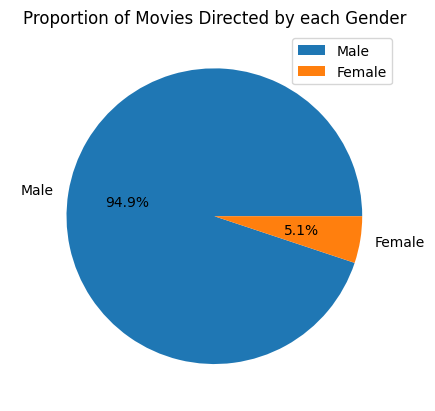

In [78]:
# Proportion of movies in dataset directed by each gender

gender_labels = df['gender'].map({1: 'Male', 0: 'Female'})
props = gender_labels.value_counts() / gender_labels.value_counts().sum()
plot = props.plot(kind='pie', autopct='%1.1f%%')
plt.ylabel(' ')
plt.title('Proportion of Movies Directed by each Gender')
plt.legend(labels=props.index, loc="best")
    
plt.show()

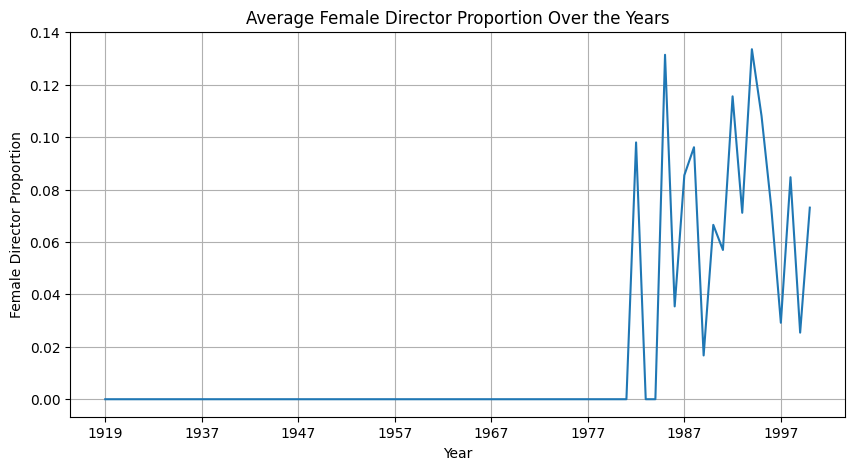

In [75]:
# Average female_director_proportion by year

plt.figure(figsize=(10, 5))
df.groupby('Year')['female_director_proportion'].mean().plot()
plt.title('Average Female Director Proportion Over the Years')
plt.xlabel('Year')
plt.ylabel('Female Director Proportion')
plt.grid(True)
plt.show()

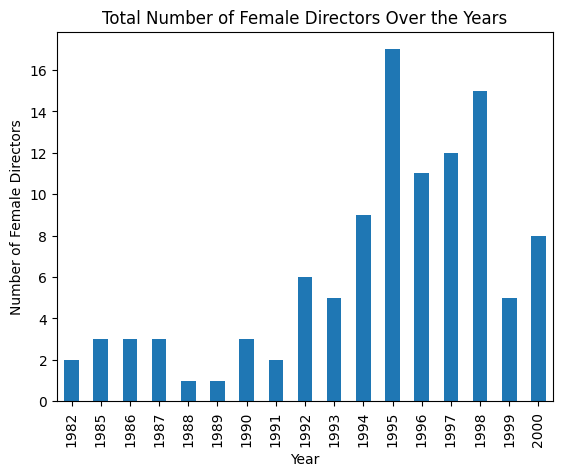

In [103]:
import matplotlib.pyplot as plt

dir_gender_by_year = merged_df.groupby('Year')['gender'].value_counts().sort_index().reset_index()

female_directors_by_year = dir_gender_by_year[dir_gender_by_year['gender'] == 'female']

# Setting the year as index
female_directors_by_year.set_index('Year', inplace=True)

# Plotting
female_directors_by_year.plot(kind='bar', legend=None)
plt.title('Total Number of Female Directors Over the Years')
plt.xlabel('Year')
plt.ylabel('Number of Female Directors')
plt.show()

In [114]:
df

,MovieID,Year,male_count,gender,female_count,User_Rating,UserID,User_Gender,User_Age,User_Occupation,...,Fantasy,Mystery,Documentary,Thriller,Comedy,Horror,Crime,Sci-Fi,male_director_proportion,female_director_proportion
0,1,1995,37.0,1,4.0,5,1,0,1,10,...,0,0,0,0,1,0,0,0,1.0,0.0
1,48,1995,3.0,1,0.0,5,1,0,1,10,...,0,0,0,0,0,0,0,0,1.0,0.0
2,48,1995,10.0,1,0.0,5,1,0,1,10,...,0,0,0,0,0,0,0,0,1.0,0.0
4,150,1995,58.0,1,13.0,5,1,0,1,10,...,0,0,0,0,0,0,0,0,1.0,0.0
6,260,1977,154.0,1,0.0,4,1,0,1,10,...,1,0,0,0,0,0,0,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086284,3513,2000,61.0,1,0.0,4,5727,1,25,4,...,0,0,0,1,0,0,0,0,1.0,0.0
1086285,3535,2000,1.0,0,7.0,2,5727,1,25,4,...,0,0,0,1,1,1,0,0,0.0,1.0
1086286,3536,2000,112.0,1,3.0,5,5727,1,25,4,...,0,0,0,0,1,0,0,0,1.0,0.0
1086287,3555,2000,7.0,1,7.0,3,5727,1,25,4,...,0,0,0,1,0,0,0,0,1.0,0.0


In [123]:
df

,MovieID,Year,male_count,gender,female_count,User_Rating,UserID,User_Gender,User_Age,User_Occupation,...,Fantasy,Mystery,Documentary,Thriller,Comedy,Horror,Crime,Sci-Fi,male_director_proportion,female_director_proportion
0,1,1995,37.0,Male,4.0,5,1,0,1,10,...,0,0,0,0,1,0,0,0,1.0,0.0
1,48,1995,3.0,Male,0.0,5,1,0,1,10,...,0,0,0,0,0,0,0,0,1.0,0.0
2,48,1995,10.0,Male,0.0,5,1,0,1,10,...,0,0,0,0,0,0,0,0,1.0,0.0
4,150,1995,58.0,Male,13.0,5,1,0,1,10,...,0,0,0,0,0,0,0,0,1.0,0.0
6,260,1977,154.0,Male,0.0,4,1,0,1,10,...,1,0,0,0,0,0,0,1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1086284,3513,2000,61.0,Male,0.0,4,5727,1,25,4,...,0,0,0,1,0,0,0,0,1.0,0.0
1086285,3535,2000,1.0,Female,7.0,2,5727,1,25,4,...,0,0,0,1,1,1,0,0,0.0,1.0
1086286,3536,2000,112.0,Male,3.0,5,5727,1,25,4,...,0,0,0,0,1,0,0,0,1.0,0.0
1086287,3555,2000,7.0,Male,7.0,3,5727,1,25,4,...,0,0,0,1,0,0,0,0,1.0,0.0


In [122]:
gender_labels = df['gender'].map({1: 'Male', 0: 'Female'})
gender_labels

0          NaN
1          NaN
2          NaN
4          NaN
6          NaN
          ... 
1086284    NaN
1086285    NaN
1086286    NaN
1086287    NaN
1086288    NaN
Name: gender, Length: 665793, dtype: object

In [137]:
gender_labels

0            Male
1            Male
2            Male
4            Male
6            Male
            ...  
1086284      Male
1086285    Female
1086286      Male
1086287      Male
1086288      Male
Name: gender, Length: 679984, dtype: object

ValueError: The number of FixedLocator locations (18), usually from a call to set_ticks, does not match the number of labels (2).

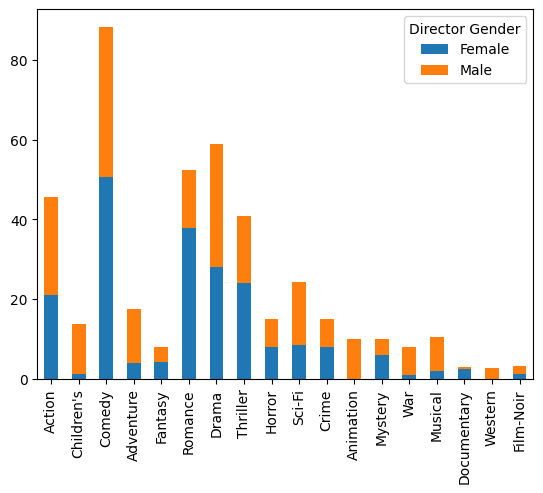

In [139]:
import matplotlib.pyplot as plt

# Mapping numerical gender values to labels
gender_labels = {1: 'Male', 0: 'Female'}
df['gender'] = df['gender'].map(gender_labels)

# Grouping data by gender and genre, and calculating counts
genre_counts_by_gender = df.groupby('gender').sum()[['Action', "Children's", 'Comedy', 'Adventure', 'Fantasy', 'Romance', 'Drama', 'Thriller', 'Horror', 'Sci-Fi', 'Crime', 'Animation', 'Mystery', 'War', 'Musical', 'Documentary', 'Western', 'Film-Noir']]

# Calculate total movies by gender
total_movies_by_gender = df['gender'].value_counts()

# Calculate percentages
genre_percentage_by_gender = genre_counts_by_gender.div(total_movies_by_gender, axis=0) * 100

# Plotting
ax = genre_percentage_by_gender.transpose().plot(kind='bar', stacked=True)

# Set custom legend
plt.legend(title='Director Gender', labels=['Female', 'Male'])

# Set custom x-axis labels
ax.set_xticklabels(['Female', 'Male'], rotation=45, ha='right')

plt.title('Percentage of Each Genre Among Movies Directed by Male and Female Directors')
plt.xlabel('Genre')
plt.ylabel('Percentage')

plt.show()

## Bias EDA

In [45]:
merged_users = ratings_df.merge(users_df[['UserID', 'User_Age', 'User_Gender', 'User_Occupation']], on='UserID')
merged_users['User_Gender'] = merged_users['User_Gender'].replace({'F': 0, 'M': 1})

In [135]:
# # Group by Age and Rating, then calculate the sum
# grouped_data = merged_users.groupby(['User_Age', 'Rating']).size().unstack().fillna(0)

# # Print the specific values
# print("Sum of Star Ratings per Unique Age:")
# print(grouped_data)

# # Plot the bar plot
# grouped_data.plot(kind='bar', stacked=True, figsize=(10, 6))

# # Set plot labels and title
# plt.xlabel('Age')
# plt.ylabel('Number of Ratings')
# plt.title('Sum of Star Ratings per Unique Age')

# # Show the plot
# plt.show()

Proportion of Star Ratings per Gender:
User_Rating         1         2         3         4         5
gender                                                       
0            0.070194  0.134087  0.303156  0.341043  0.151520
1            0.054832  0.106425  0.262966  0.349554  0.226223


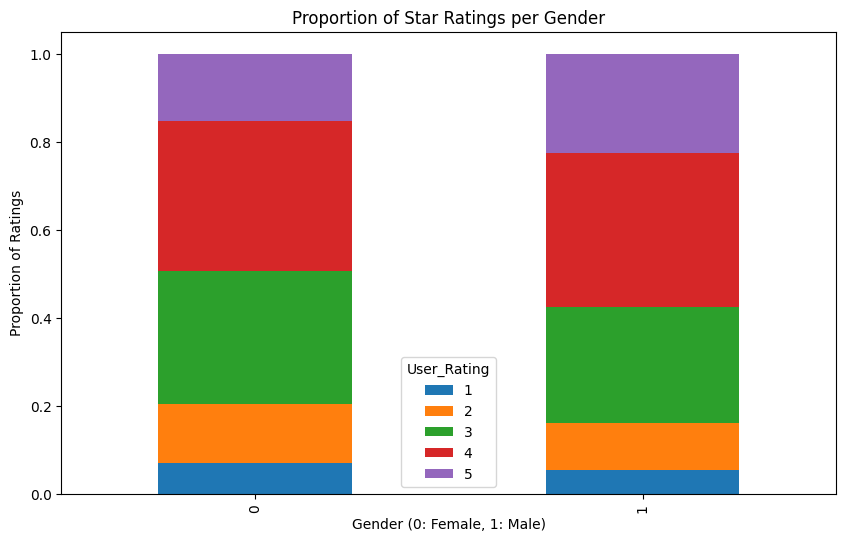

In [134]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Director Gender and Rating received, then calculate the count
grouped_data_gender = df.groupby(['gender', 'User_Rating']).size().unstack().fillna(0)

# Calculate the total count of ratings received for each director gender
total_ratings_by_gender = df['gender'].value_counts()

# Calculate proportions by dividing each count by the total count of ratings received for each director gender
proportion_data_gender = grouped_data_gender.div(total_ratings_by_gender, axis=0)

# Print the specific values
print("Proportion of Star Ratings per Gender:")
print(proportion_data_gender)

# Plot the bar plot
proportion_data_gender.plot(kind='bar', stacked=True, figsize=(10, 6))

# Set plot labels and title
plt.xlabel('Gender (0: Female, 1: Male)')
plt.ylabel('Proportion of Ratings')
plt.title('Proportion of Star Ratings per Gender')

# Show the plot
plt.show()

## Checking for bias with AIF360

In [48]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing

# Define the protected attributes
protected_attributes = ['male_director_proportion']

# Define the favorable and unfavorable labels
favorable_classes = [5]  # Assuming 5 is a high rating (favorable)

# Create a StandardDataset
dataset = StandardDataset(df, label_name='User_Rating', favorable_classes=favorable_classes,
                          protected_attribute_names=protected_attributes,
                          privileged_classes=[[1]])  # Only one class for User_Gender (e.g., male is privileged)

# Calculate the disparate impact before any mitigation
metric_before = BinaryLabelDatasetMetric(dataset, unprivileged_groups=[{'male_director_proportion': 0}],
                                         privileged_groups=[{'male_director_proportion': 1}])
disparate_impact_before = metric_before.disparate_impact()

print("Disparate Impact Before Mitigation:", disparate_impact_before)
print("Statistical Parity Difference Before Mitigation:", metric_before.statistical_parity_difference())

# Apply Reweighing as a bias mitigation technique
rw = Reweighing(unprivileged_groups=[{'male_director_proportion': 0}], privileged_groups=[{'male_director_proportion': 1}])
dataset_transformed = rw.fit_transform(dataset)

# Calculate the disparate impact after mitigation
metric_after = BinaryLabelDatasetMetric(dataset_transformed, unprivileged_groups=[{'male_director_proportion': 0}],
                                        privileged_groups=[{'male_director_proportion': 1}])
disparate_impact_after = metric_after.disparate_impact()

print("Disparate Impact After Mitigation:", disparate_impact_after)
print("Statistical Parity Difference After Mitigation:", metric_after.statistical_parity_difference())

Disparate Impact Before Mitigation: 0.6631799095216503
Statistical Parity Difference Before Mitigation: -0.07672487054948571
Disparate Impact After Mitigation: 0.9999999999999993
Statistical Parity Difference After Mitigation: -1.3877787807814457e-16


### Recommender System

In [49]:
import warnings
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import jaccard_score

# Suppress FutureWarnings related to is_sparse
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.utils.validation")

In [50]:
# Predict Rating Model

# Select features and target variable

features = ['male_count', 'female_count', 'User_Age', 'User_Occupation', 'Documentary', 'Romance', 'Fantasy', 'Western', 'Thriller',
            'Children\'s', 'Film-Noir', 'Drama', 'Comedy', 'Adventure', 'Horror', 'Crime', 'Action', 'Mystery', 'War', 'Musical', 'Animation', 'Sci-Fi',
            'male_director_proportion', 'female_director_proportion']

target = 'User_Rating'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 1.163013337804836


In [54]:
#Predicting rating for men and women
# Select common features
common_features = ['male_count', 'female_count', 'User_Age', 'User_Occupation', 'Documentary', 'Romance', 'Fantasy', 'Western', 'Thriller',
                   'Children\'s', 'Film-Noir', 'Drama', 'Comedy', 'Adventure', 'Horror', 'Crime', 'Action', 'Mystery', 'War', 'Musical', 'Animation', 'Sci-Fi',
                   'male_director_proportion', 'female_director_proportion']

# Filter data for men and women separately
df_men = df[df['male_director_proportion'] == 1]
df_women = df[df['male_director_proportion'] == 0]

# Function to train and evaluate a model
def train_and_evaluate(data, gender):
    X = data[common_features]
    y = data['User_Rating']

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a linear regression model
    model = LinearRegression()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Make predictions on the testing data
    y_pred = model.predict(X_test)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error for {gender}: {mse}')

# Train and evaluate models for men and women
train_and_evaluate(df_men, 'Men')
train_and_evaluate(df_women, 'Women')

Mean Squared Error for Men: 1.1562358906143888
Mean Squared Error for Women: 1.1652852436909205


In [140]:
# Create a Movie-User matrix
movie_user_matrix = df.pivot_table(index='MovieID', columns='UserID', values='User_Rating', fill_value=0)

# Function to calculate Jaccard similarity between two movies
def calculate_jaccard_similarity(movie1, movie2):
    intersection = sum((movie1 > 0) & (movie2 > 0))
    union = sum((movie1 > 0) | (movie2 > 0))
    
    if union == 0:
        return 0
    
    return intersection / union

# Function to generate movie recommendations based on Jaccard similarity and genre
def generate_movie_recommendations(user_id, movie_user_matrix, df_movies, top_n=5):
    # Get movies already rated by the user
    user_rated_movies = movie_user_matrix[user_id][movie_user_matrix[user_id] > 0].index
    
    # Initialize an empty DataFrame to store recommendations
    recommendations = pd.DataFrame(columns=['MovieID'])
    
    for movie_id in user_rated_movies:
        target_movie_ratings = movie_user_matrix.loc[movie_id]
        similarities = movie_user_matrix.apply(lambda x: calculate_jaccard_similarity(target_movie_ratings, x), axis=1)
    
        # Sort movies by Jaccard similarity in descending order
        similar_movies = similarities.sort_values(ascending=False)
    
        # Exclude movies already rated by the user
        similar_movies = similar_movies.drop(user_rated_movies)
    
        # Append recommendations to the DataFrame
        recommendations = pd.concat([recommendations, similar_movies.head(top_n).reset_index()], ignore_index=True)
    
    # Drop duplicates and keep the top N recommendations
    recommendations = recommendations.drop_duplicates().head(top_n)
    
    # Rename the column '0' to 'Jaccard_Score'
    recommendations = recommendations.rename(columns={0: 'Jaccard_Similarity'})
    
    return recommendations

# Example: Recommend top 5 movies for User ID 1
user_id_to_recommend = 1
recommended_movies = generate_movie_recommendations(user_id_to_recommend, movie_user_matrix, df[['MovieID']], top_n=5)

print(f"Top 5 Recommended Movies for User ID {user_id_to_recommend}:\n", recommended_movies)

Top 5 Recommended Movies for User ID 1:
   MovieID  Jaccard_Similarity
0    1265            0.459450
1     356            0.403549
2    1580            0.394260
3    2396            0.382033
4    1196            0.379151
